In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# F4(Mbuti, UMIN Cap; X1, X2) extreme values Subplot

In [4]:
# Calculates range of sizes for SNP counts
def _size_scaler(series, min_s=50, max_s=800):
    lo, hi = series.min(), series.max()
    if hi == lo:
        return lambda x: (min_s + max_s) / 2
    return lambda x: min_s + (x - lo) * (max_s - min_s) / (hi - lo)

# Set the features for the plotting and builts dataframe for negative values 
def make_panel_data_negative(df, pop3_order, z_thresh=2.8, snp_thresh=10_000, group_spacer=1.0):
    """Returns plot_df, group_ranges, color_map, size_scale."""
    df = df.copy()
    # SE and significance
    df["SE"] = df.apply(lambda r: abs(r["D-stat"]/r["Z"]) if r["Z"] != 0 else np.nan, axis=1)
    df = df[(df["Z"].abs() > z_thresh) & (df["SNPs"] > snp_thresh)]
    # keep only requested groups (and in that order)
    pop3_order = [g for g in pop3_order if g in df["Pop3"].unique()]
    # colors by groupd
    cmap = plt.get_cmap("tab10")
    color_map = {g: cmap(i % 10) for i, g in enumerate(pop3_order)}
    df["color"] = df["Pop3"].map(color_map)

    # build single column with gaps between groups
    rows, y, ranges = [], 0, {}
    for g in pop3_order:
        sub = df[df["Pop3"] == g].sort_values("D-stat")
        if sub.empty: 
            continue
        n = len(sub)
        sub = sub.assign(y=np.arange(y, y+n))
        rows.append(sub)
        ranges[g] = (y, y+n-1)
        y += n + group_spacer

    if not rows:
        return pd.DataFrame(), {}, color_map, _size_scaler(pd.Series([1]))

    plot_df = pd.concat(rows, ignore_index=True)
    size_scale = _size_scaler(plot_df["SNPs"])
    return plot_df, ranges, color_map, size_scale

# Set the features for the plotting and builts dataframe for positive values 
def make_panel_data_positive(df, pop3_order, z_thresh=2.8, snp_thresh=10_000, group_spacer=1.0):
    """Returns plot_df, group_ranges, color_map, size_scale."""
    df = df.copy()
    # SE and significance
    df["SE"] = df.apply(lambda r: abs(r["D-stat"]/r["Z"]) if r["Z"] != 0 else np.nan, axis=1)
    df = df[(df["Z"].abs() > z_thresh) & (df["SNPs"] > snp_thresh)]
    # keep only requested groups (and in that order)
    pop3_order = [g for g in pop3_order if g in df["Pop4"].unique()]
    # colors by group
    cmap = plt.get_cmap("tab10")
    color_map_ps = {g: cmap(i % 10) for i, g in enumerate(pop3_order)}
    df["color"] = df["Pop4"].map(color_map_ps)

    # build single column with gaps between groups
    rows, y, ranges_ps = [], 0, {}
    for g in pop3_order:
        sub = df[df["Pop4"] == g].sort_values("D-stat")
        if sub.empty: 
            continue
        n = len(sub)
        sub = sub.assign(y=np.arange(y, y+n))
        rows.append(sub)
        ranges_ps[g] = (y, y+n-1)
        y += n + group_spacer

    if not rows:
        return pd.DataFrame(), {}, color_map, _size_scaler(pd.Series([1]))

    plot_df_ps = pd.concat(rows, ignore_index=True)
    size_scale_ps = _size_scaler(plot_df["SNPs"])
    return plot_df_ps, ranges_ps, color_map_ps, size_scale_ps

#Draw the plot and legend

def plot_f4_panel(ax, plot_df, group_ranges, color_map, pop3_order,
                  size_scale, title="", show_legends=False, put_labels_outside=False):
    """Draws one panel into ax."""
    if plot_df.empty:
        ax.set_axis_off()
        ax.set_title(title)
        return

    # scatter + error bars
    sizes = plot_df["SNPs"].map(size_scale)
    ax.scatter(plot_df["D-stat"], plot_df["y"], s=sizes,
               c=plot_df["color"], edgecolor="k", alpha=0.9, zorder=3)
    ax.errorbar(plot_df["D-stat"], plot_df["y"], xerr=3*plot_df["SE"],
                fmt="none", ecolor="black", elinewidth=1, capsize=2, alpha=0.9, zorder=2)
    
    #Set the axis
    ax.set_xlim(-0.05, 0.02)  

    # y ticks
    ax.set_yticks(plot_df["y"])
    ax.set_yticklabels(plot_df["Pop4"])

    # reference line + grid
    ax.axvline(0, linestyle="--", linewidth=1, color="gray", zorder=1)
    ax.grid(axis="y", linestyle=":", alpha=0.25)

    ax.set_xlabel("D-statistic")
    ax.set_ylabel("X2")
    ax.set_title(title)

    # group labels on the right
    xmin, xmax = ax.get_xlim()

    for g, (y0, y1) in group_ranges.items():
        yc = (y0 + y1) / 2
        ax.text(0.025, yc, g, ha="right", va="center",
                rotation=90,   
                fontsize=10, fontweight="bold", color=color_map[g], clip_on=False)
        # separators
        ax.hlines([y0-0.5, y1+0.5], xmin, xmax, colors="lightgray",
                  linestyles=":", linewidth=0.8, zorder=0)

    # optional per-axes legends
    if show_legends:
        handles = [plt.Line2D([0],[0], marker='o', color='w', label=g,
                               markerfacecolor=color_map[g], markeredgecolor='k', markersize=8)
                   for g in pop3_order]
        leg1 = ax.legend(handles=handles, title="X1 (Pop3)", loc="upper left")
        for s, lab in [(10_000, "10k"), (50_000, "50k"), (100_000, "100k")]:
            ax.scatter([], [], s=size_scale(s), c='w', edgecolor='k', label=lab)
        leg2 = ax.legend(title="SNPs (size)", loc="lower left")
        ax.add_artist(leg1)


#plot positive values
def plot_f4_panel_positive(ax, plot_df, group_ranges, color_map, pop3_order,
                  size_scale, title="", show_legends=False, put_labels_outside=False):
    """Draws one panel into ax."""
    if plot_df.empty:
        ax.set_axis_off()
        ax.set_title(title)
        return

    # scatter + error bars
    sizes = plot_df["SNPs"].map(size_scale)
    ax.scatter(plot_df["D-stat"], plot_df["y"], s=sizes,
               c=plot_df["color"], edgecolor="k", alpha=0.9, zorder=3)
    ax.errorbar(plot_df["D-stat"], plot_df["y"], xerr=3*plot_df["SE"],
                fmt="none", ecolor="black", elinewidth=1, capsize=2, alpha=0.9, zorder=2)
    
    # Set the axis
    ax.set_xlim(-0.02, 0.04)  

    # y ticks
    ax.set_yticks(plot_df["y"])
    ax.set_yticklabels(plot_df["Pop3"])

    # reference line + grid
    ax.axvline(0, linestyle="--", linewidth=1, color="gray", zorder=1)
    ax.grid(axis="y", linestyle=":", alpha=0.25)

    ax.set_xlabel("D-statistic")
    ax.set_ylabel("X1")
    ax.set_title(title)

    # group labels on the right
    xmin, xmax = ax.get_xlim()

    for g, (y0, y1) in group_ranges.items():
        yc = (y0 + y1) / 2
        ax.text(0.07, yc, g, ha="right", va="center",
                rotation=90,   
                fontsize=10, fontweight="bold", color=color_map[g], clip_on=False)
        # separators
        ax.hlines([y0-0.5, y1+0.5], xmin, xmax, colors="lightgray",
                  linestyles=":", linewidth=0.8, zorder=0)

    # optional per-axes legends
    if show_legends:
        handles = [plt.Line2D([0],[0], marker='o', color='w', label=g,
                               markerfacecolor=color_map[g], markeredgecolor='k', markersize=8)
                   for g in pop3_order]
        leg1 = ax.legend(handles=handles, title="X1 (Pop3)", loc="upper left")
        for s, lab in [(10_000, "10k"), (50_000, "50k"), (100_000, "100k")]:
            ax.scatter([], [], s=size_scale(s), c='w', edgecolor='k', label=lab)
        leg2 = ax.legend(title="SNPs (size)", loc="lower left")
        ax.add_artist(leg1)



In [5]:
# --- load ---
df_a = pd.read_csv("/Users/macbook/Documents/Master/Master_Thesis/Results/F4/Plotting_F4/f4_Mbuti_Cap_X1_x2_extremes.out", sep="\t")
df_b = pd.read_csv("/Users/macbook/Documents/Master/Master_Thesis/Results/F4/Plotting_F4/f4_Mbuti_Cap_X1_x2_extremes_positive.out", sep="\t")

#Order of groups
ancient_groups = [
    "Canada_MDorset.AG",
    "Canada_MDorset.SG",
    "Canada_LateDorset.SG",
    "Greenland_Saqqaq.SG",
    "Eskimo_Chaplin.DG"
]

# Prepare both panels
plot_df_a, ranges_a, colors_a, size_a = make_panel_data_negative(df_a, ancient_groups)
plot_df_b, ranges_b, colors_b, size_b = make_panel_data_positive(df_b, ancient_groups)


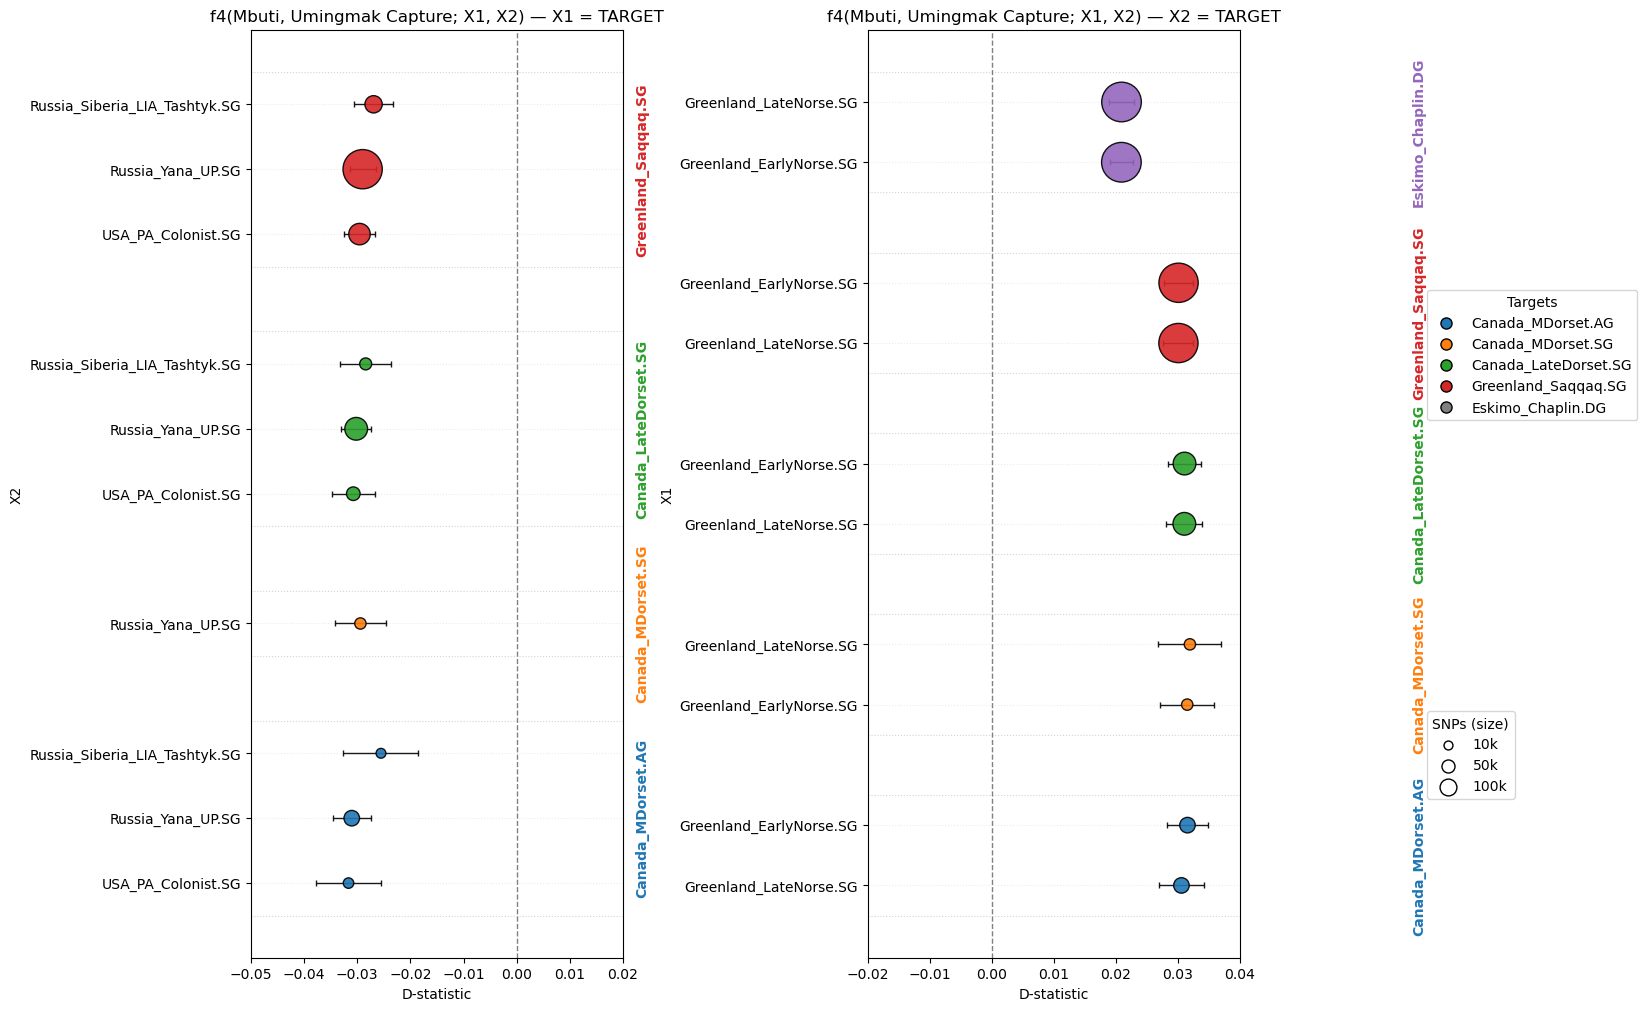

In [6]:
# Create the subplots 
fig, axs = plt.subplots(ncols=2, sharex=False, figsize=(14, 10), constrained_layout=True)

plot_f4_panel(axs[0], plot_df_a, ranges_a, colors_a, ancient_groups, size_a,
              title="f4(Mbuti, Umingmak Capture; X1, X2) — X1 = TARGET",
              show_legends=False, put_labels_outside=True)

plot_f4_panel_positive(axs[1], plot_df_b, ranges_b, colors_b, ancient_groups, size_b,
              title="f4(Mbuti, Umingmak Capture; X1, X2) — X2 = TARGET",
              show_legends=False, put_labels_outside=True)  # last panel: put labels outside

# Make a single, figure-level legend on the right (colors shared across panels)
shared_handles = [plt.Line2D([0],[0], marker='o', color='w', label=g,
                              markerfacecolor=colors_a.get(g, 'gray'), markeredgecolor='k', markersize=8)
                  for g in ancient_groups if g in (colors_a.keys()|colors_b.keys())]
fig.legend(handles=shared_handles, title="Targets", loc="center left", bbox_to_anchor=(1.01, 0.65))

# Size legend (figure-level)
proxy = []
for s, lab in [(10_000, "10k"), (50_000, "50k"), (100_000, "100k")]:
    proxy.append(axs[0].scatter([], [], s=size_a(s if callable(size_a) else 10_000),
                                c='w', edgecolor='k', label=lab))
fig.legend(handles=proxy, title="SNPs (size)", loc="center left", bbox_to_anchor=(1.01, 0.25))

#plt.savefig("f4_Mbuti_UmCap_x1_x2.pdf")  

plt.show()

# F4(Mbuti, Umin SG; X1, X2) Extrem values

In [7]:
# --- load ---
df_a = pd.read_csv("/Users/macbook/Documents/Master/Master_Thesis/Results/F4/Plotting_F4/f4_Mbuti_SG_X1_x2_extremes.out", sep="\t")
df_b = pd.read_csv("/Users/macbook/Documents/Master/Master_Thesis/Results/F4/Plotting_F4/f4_Mbuti_SG_X1_x2_extremes_positive.out", sep="\t")

#Order of groups
ancient_groups = [
    "Canada_MDorset.AG",
    "Canada_MDorset.SG",
    "Canada_LateDorset.SG",
    "Greenland_Saqqaq.SG",
    "Eskimo_Chaplin.DG"
]

# Prepare both panels
plot_df_a, ranges_a, colors_a, size_a = make_panel_data_negative(df_a, ancient_groups)
plot_df_b, ranges_b, colors_b, size_b = make_panel_data_positive(df_b, ancient_groups)

#-----------Hasta acá bien


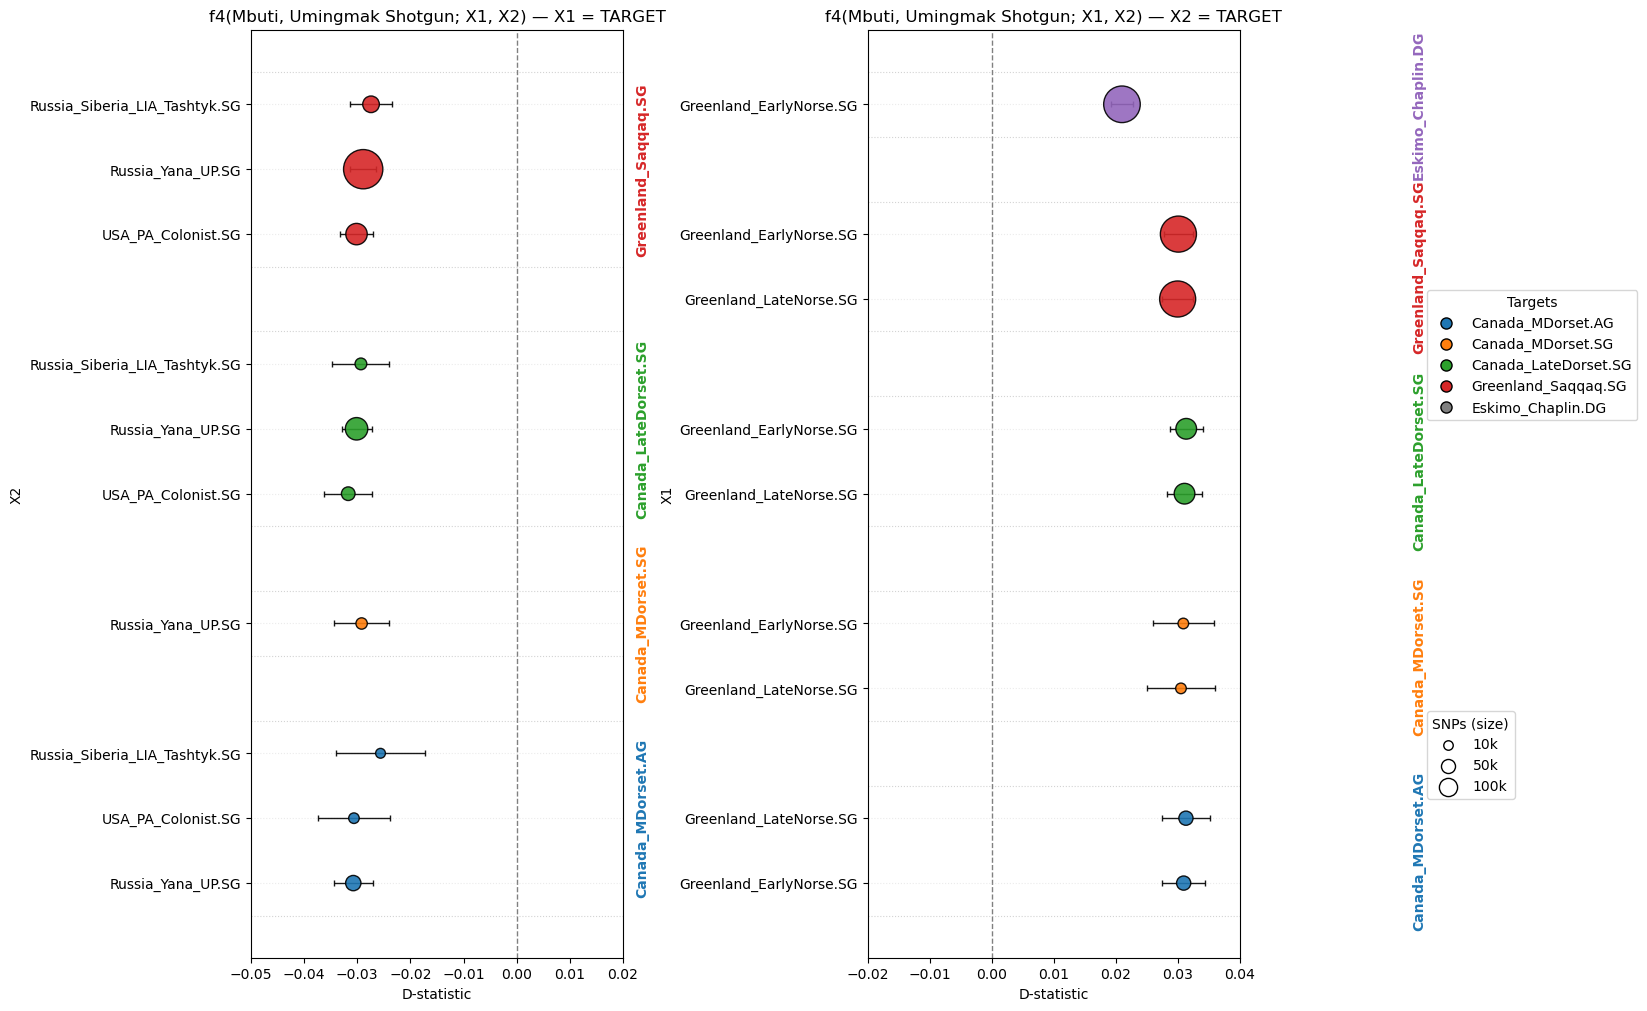

In [8]:
# Create the subplots
fig, axs = plt.subplots(ncols=2, sharex=False, figsize=(14, 10), constrained_layout=True)

plot_f4_panel(axs[0], plot_df_a, ranges_a, colors_a, ancient_groups, size_a,
              title="f4(Mbuti, Umingmak Shotgun; X1, X2) — X1 = TARGET",
              show_legends=False, put_labels_outside=True)

plot_f4_panel_positive(axs[1], plot_df_b, ranges_b, colors_b, ancient_groups, size_b,
              title="f4(Mbuti, Umingmak Shotgun; X1, X2) — X2 = TARGET",
              show_legends=False, put_labels_outside=True)  # last panel: put labels outside

# Make a single, figure-level legend on the right (colors shared across panels)
shared_handles = [plt.Line2D([0],[0], marker='o', color='w', label=g,
                              markerfacecolor=colors_a.get(g, 'gray'), markeredgecolor='k', markersize=8)
                  for g in ancient_groups if g in (colors_a.keys()|colors_b.keys())]
fig.legend(handles=shared_handles, title="Targets", loc="center left", bbox_to_anchor=(1.01, 0.65))

# Size legend (figure-level)
proxy = []
for s, lab in [(10_000, "10k"), (50_000, "50k"), (100_000, "100k")]:
    proxy.append(axs[0].scatter([], [], s=size_a(s if callable(size_a) else 10_000),
                                c='w', edgecolor='k', label=lab))
fig.legend(handles=proxy, title="SNPs (size)", loc="center left", bbox_to_anchor=(1.01, 0.25))
# Save figures
#plt.savefig("f4_Mbuti_UmSG_x1_x2.pdf")   # vector for LaTeX/Word

plt.show()

# F4 for Continuity

In [9]:
# Calculates range of sizes for SNP counts
def _size_scaler(series, min_s=50, max_s=800):
    lo, hi = series.min(), series.max()
    if hi == lo:
        return lambda x: (min_s + max_s) / 2
    return lambda x: min_s + (x - lo) * (max_s - min_s) / (hi - lo)

def make_panel_data(df, test_order, z_thresh=2.8, snp_thresh=10000, group_spacer=1.0):
    """Returns plot_df, group_ranges, color_map, size_scale."""
    df = df.copy()
    # SE and significance
    df["SE"] = df.apply(lambda r: abs(r["D-stat"]/r["Z"]) if r["Z"] != 0 else np.nan, axis=1)
    df = df[(df["Z"].abs() > z_thresh) & (df["SNPs"] > snp_thresh)]
    # keep only requested groups (and in that order)
    test_order = [g for g in test_order if g in df["Pop2"].unique()]
    
    # ---- Color map logic ----
    cmap = plt.get_cmap("tab20")
    color_map = {}

    for i, g in enumerate(test_order):
        # pick the two colors (dark/light) for this group
        base_idx = (i * 2) % 20
        dark, light = cmap(base_idx), cmap(base_idx + 1)

        # assign based on Pop4 type
        color_map[(g, "UMIN_Cap_Bleached")] = dark
        color_map[(g, "UMIN_SG_Bleached_merged")] = light

    # Assign colors to dataframe rows
    df["color"] = df.apply(
        lambda r: color_map.get((r["Pop2"], r["Pop4"]), "grey"), axis=1
    )

    # build single column with gaps between groups
    rows, y, ranges = [], 0, {}
    for g in test_order:
        sub = df[df["Pop2"] == g]
        if sub.empty: 
            continue
        n = len(sub)
        sub = sub.assign(y=np.arange(y, y+n))
        rows.append(sub)
        ranges[g] = (y, y+n-1)
        y += n + group_spacer

    if not rows:
        return pd.DataFrame(), {}, {}, color_map, _size_scaler(pd.Series([1]))

    plot_df = pd.concat(rows, ignore_index=True)
    size_scale = _size_scaler(plot_df["SNPs"])
    return plot_df, ranges, color_map, size_scale



In [10]:
# For plotting
def plot_f4_panel(plot_df, ranges, color_map, size_scale, xlabel="f₄(Mbuti, Test; xᵢ, Umingmak)", figsize=(8,10), show_snp_legend=True):
    fig, ax = plt.subplots(figsize=figsize)
    
    # Scatter plot of D-statistics
    for g, (y0, y1) in ranges.items():
        sub = plot_df[plot_df["Pop2"] == g]
        ax.errorbar(
            sub["D-stat"], sub["y"], 
            xerr=3*sub["SE"], fmt="none", ecolor=sub["color"].iloc[0], 
            elinewidth=1, alpha=0.6, capsize=2, lw=1, zorder=2
        )
        ax.scatter(
            sub["D-stat"], sub["y"], 
            s=sub["SNPs"].apply(size_scale),
            color=sub["color"],
            edgecolor="k", lw=0.5, alpha=0.9, label=g
        )

        # Shade group background
        ax.axhspan(y0-0.5, y1+0.5, color=sub["color"].iloc[0], alpha=0.08, lw=0)

    # Aesthetic adjustments
    ax.axvline(0, color="gray", lw=1, linestyle="--", alpha=0.6)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel("xᵢ populations", fontsize=12)
    ax.set_yticks(plot_df["y"])
    ax.set_yticklabels(plot_df["Pop3"], fontsize=9)
    ax.invert_yaxis()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis="x", labelsize=10)
    ax.tick_params(axis="y", labelsize=9)
    
    # Group labels on right side    
    for g, (y0, y1) in ranges.items():
        # find any color for this group (prefer the Cap_Bleached if available)
        color_candidates = [v for (gg, pp), v in color_map.items() if gg == g]
        if color_candidates:
            label_color = color_candidates[0]
        else:
            label_color = "black"
        
        ax.text(ax.get_xlim()[1]*1.02, (y0+y1)/2, g, va="center", ha="left",
                fontsize=10, color=label_color, weight="bold")



    # --- SNP-size legend ---
    if show_snp_legend:
        snp_values = [10_000, 50_000, 100_000]
        legend_labels = ["10k SNPs", "50k SNPs", "100k SNPs"]

        # Create fake scatter points for legend
        handles = [
            plt.scatter([], [], s=size_scale(v), facecolor='gray', edgecolor='k', lw=0.5)
            for v in snp_values
        ]

        legend = ax.legend(
            handles, legend_labels, title="SNP count (circle size)",
            loc="upper left", bbox_to_anchor=(1.02, 1),
            scatterpoints=1, frameon=False, labelspacing=1,
            handletextpad=1, borderpad=0.8
        )

        # Make the title bold for readability
        plt.setp(legend.get_title(), fontweight='bold')

    plt.tight_layout()
    plt.show()


In [11]:
#load data
df = pd.read_csv("/Users/macbook/Documents/Master/Master_Thesis/Results/F4/Results_downloaded/f4_pop_continuity2.out", sep="\t")
umin = ["UMIN_Cap_Bleached", "UMIN_SG_Bleached_merged"]
df = df[df["Pop4"].isin(umin)]

#Order of groups
ancient_groups = [
    "Greenland_Saqqaq.SG",
    "Canada_MDorset.AG",
    "Canada_MDorset.SG",
    "Canada_LateDorset.SG",
    "USA_AK_PaleoAleut.AG",
    "Canada_700BP.SG",
    "Canada_Thule.SG"
]

plot_df, ranges, color_map, size_scale = make_panel_data(df, ancient_groups)
plot_df.head()

,Pop1,Pop2,Pop3,Pop4,D-stat,Z,BABA,ABBA,SNPs,SE,color,y
0,Mbuti.DG,Greenland_Saqqaq.SG,Canada_LateDorset.SG,UMIN_Cap_Bleached,-0.003625,-3.520,8814,9536,199287,0.001030,"(0.12156862745098039, 0.4666666666666667, 0.70...",0.0
1,Mbuti.DG,Greenland_Saqqaq.SG,Canada_LateDorset.SG,UMIN_SG_Bleached_merged,-0.003369,-3.191,7095,7636,160365,0.001056,"(0.6823529411764706, 0.7803921568627451, 0.909...",1.0
2,Mbuti.DG,Greenland_Saqqaq.SG,USA_AK_PaleoAleut.AG,UMIN_Cap_Bleached,0.009697,12.532,32273,26610,584012,0.000774,"(0.12156862745098039, 0.4666666666666667, 0.70...",2.0
3,Mbuti.DG,Greenland_Saqqaq.SG,USA_AK_PaleoAleut.AG,UMIN_SG_Bleached_merged,0.009687,12.128,26306,21690,476441,0.000799,"(0.6823529411764706, 0.7803921568627451, 0.909...",3.0
4,Mbuti.DG,Greenland_Saqqaq.SG,Canada_700BP.SG,UMIN_Cap_Bleached,0.017572,14.470,5445,3880,89074,0.001214,"(0.12156862745098039, 0.4666666666666667, 0.70...",4.0


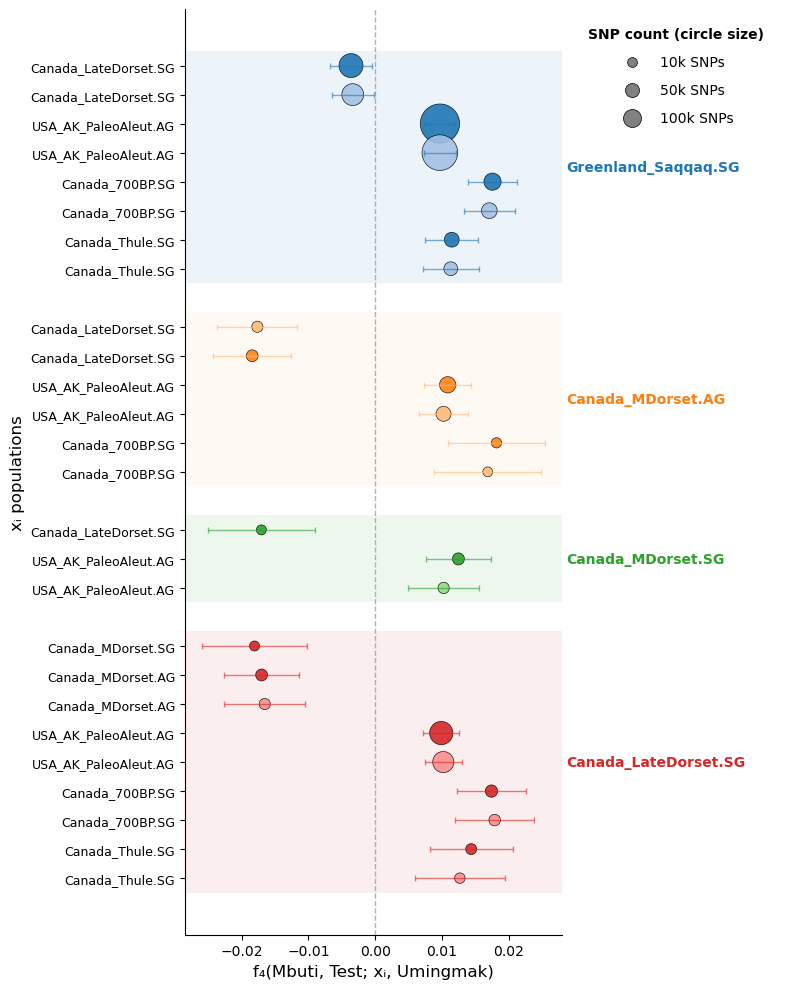

In [12]:
plot_f4_panel(plot_df, ranges, color_map, size_scale, show_snp_legend=True)